In [1]:
import pandas as pd
import os
from os.path import isfile, isdir
import statistics
from metadata import metadata
from matplotlib import pyplot as plt
import scipy.stats as stats
from collections import deque


def find_longest_list_index_in_Series(s):
    max_length = -1
    max_index = None
    s_to_list = s.tolist()
    for i in range(len(s_to_list)):
        cur_length = len(s_to_list[i])
        if cur_length > max_length:
            max_length = cur_length
            max_index = i

    # print(s.index.tolist())
    return s.index.tolist()[max_index]


def deduplicate(df):
    idx = df.groupby('citationName')['citedReferences'].apply(lambda x: find_longest_list_index_in_Series(x))
    result_df = df.loc[idx].reset_index(drop=True)

    return result_df


def get_data_frame(path):
    df = pd.read_csv(path)
    df['citedReferences'] = df['citedReferences'].apply(lambda x: x.split('$$@$$'))

    # return df
    return deduplicate(df)


def sum_power_2(length: int):
    res = 0
    for i in range(length):
        res += (2 ** i) / (i+1)

    return res


def promotion_effect_score(df, total_num_citations, total_num_references):
    if total_num_citations == 0:
        return 0

    res = 0
    for item in df['citedReferences']:
        res += sum_power_2(len(item))

    return res / (total_num_citations * total_num_references)


def promotion_effect_score_group(group_dir):
    res = []

    for f in os.listdir(group_dir):
        if f.endswith(".csv"):
            paperId = f.split('.')[0]
            full_relative_path = group_dir + "/" + f
            if isfile(full_relative_path):
                # print("reading: {}".format(full_relative_path))
                df = get_data_frame(full_relative_path)
                res.append(
                    promotion_effect_score(df, metadata[paperId]["num citations"], metadata[paperId]["num references"]))

    return res


def promotion_effect_dispersion(df, total_num_references):
    paper_promotion = {}
    for item in df['citedReferences']:
        promotion_share = sum_power_2(len(item)) / len(item)
        for paper in item:
            if paper not in paper_promotion:
                paper_promotion[paper] = [promotion_share, 1]
            else:
                paper_promotion[paper][0] += promotion_share
                paper_promotion[paper][1] += 1

    # promotion_received = [paper_promotion[paper][0] / (paper_promotion[paper][1] * total_num_references) for paper in
    #                       paper_promotion.keys()]
    promotion_received = [paper_promotion[paper][0] / total_num_references for paper in paper_promotion.keys()]

    if len(promotion_received) == 0:
        return 0
    return statistics.pstdev(promotion_received)


def promotion_effect_dispersion_group(group_dir):
    res = []

    for f in os.listdir(group_dir):
        if f.endswith(".csv"):
            paperId = f.split('.')[0]
            full_relative_path = group_dir + "/" + f
            if isfile(full_relative_path):
                df = get_data_frame(full_relative_path)
                res.append(
                    promotion_effect_dispersion(df, metadata[paperId]["num references"]))

    return res


def plot_two_groups(group1, group2, metric):
    labels = [group1.split('/')[-1], group2.split('/')[-1]]
    if metric == "promotion score":
        data = [promotion_effect_score_group(group1), promotion_effect_score_group(group2)]
    elif metric == "promotion dispersion":
        data = [promotion_effect_dispersion_group(group1), promotion_effect_dispersion_group(group2)]
    else:
        print("metric can only be 'promotion score' or 'promotion dispersion'")
        exit(1)

    plt.figure()
    plt.boxplot(data, meanline=True)
    plt.yscale('log')
    plt.xticks([1,2], labels)
    plt.xlabel("groups")
    plt.ylabel(metric)
    plt.title("{} distribution box plot".format(metric))

    # plt.show()
    plt.savefig("{}-{}-{}".format(labels[0], labels[1], '_'.join(metric.split(' '))))


def statistical_test_two_groups(group1, group2, metric):
    labels = [group1.split('/')[-1], group2.split('/')[-1]]
    if metric == "promotion score":
        data = [promotion_effect_score_group(group1), promotion_effect_score_group(group2)]
    elif metric == "promotion dispersion":
        data = [promotion_effect_dispersion_group(group1), promotion_effect_dispersion_group(group2)]
    else:
        print("metric can only be 'promotion score' or 'promotion dispersion'")
        exit(1)

    statistic, p_value = stats.mannwhitneyu(data[0], data[1])

    # Print the results
    print(f"Mann-Whitney U Statistic: {statistic}")
    print(f"P-value: {p_value}")

    # Check for significance
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference between {} of {} and {} papers.".format(metric, labels[0], labels[1]))
    else:
        print("Fail to reject the null hypothesis. No significant difference between {} of {} and {} papers.".format(metric, labels[0], labels[1]))



def citation_pattern(df, total_num_citations):
    res = {}
    for item in df['citedReferences']:
        cur_num = len(item)
        if cur_num not in res:
            res[cur_num] = 1
        else:
            res[cur_num] += 1

    res[0] = total_num_citations - df.shape[0]
    return res


def citation_pattern_group(group_dir, file_name):
    aggregated_citation_pattern_small = {}
    aggregated_citation_pattern_median = {}
    aggregated_citation_pattern_large = {}
    for f in os.listdir(group_dir):
        paperId = f.split('.')[0]
        full_relative_path = group_dir + "/" + f
        if isfile(full_relative_path):
            df = get_data_frame(full_relative_path)
            cur_citation_pattern = citation_pattern(df, metadata[paperId]["num citations"])
            for key in cur_citation_pattern:
                if key > 5:
                    key2 = 6
                    if key > 10:
                        key3 = 11
                        if key > 20:
                            key4 = 21
                        else:
                            key4 = key
                        if key4 not in aggregated_citation_pattern_large:
                            aggregated_citation_pattern_large[key4] = cur_citation_pattern[key]
                        else:
                            aggregated_citation_pattern_large[key4] += cur_citation_pattern[key]
                    else:
                        key3 = key
                    if key3 not in aggregated_citation_pattern_median:
                        aggregated_citation_pattern_median[key3] = cur_citation_pattern[key]
                    else:
                        aggregated_citation_pattern_median[key3] += cur_citation_pattern[key]
                else:
                    key2 = key
                if key2 not in aggregated_citation_pattern_small:
                    aggregated_citation_pattern_small[key2] = cur_citation_pattern[key]
                else:
                    aggregated_citation_pattern_small[key2] += cur_citation_pattern[key]

    sorted_keys_small = tuple(sorted(aggregated_citation_pattern_small.keys()))
    labels_small = [str(k) if k <= 5 else ">5" for k in sorted_keys_small]
    sizes_small = [aggregated_citation_pattern_small[k] for k in sorted_keys_small]
    plt.figure()
    plt.pie(sizes_small, labels=labels_small, startangle=90, shadow=False, explode=(0.1,)*len(labels_small),
            autopct='%1.2f%%')
    plt.savefig("{}_small".format(file_name))

    sorted_keys_median = tuple(sorted(aggregated_citation_pattern_median.keys()))
    labels_median = [str(k) if k <= 10 else ">10" for k in sorted_keys_median]
    sizes_median = [aggregated_citation_pattern_median[k] for k in sorted_keys_median]
    plt.figure()
    plt.pie(sizes_median, labels=labels_median, startangle=90, shadow=False, explode=(0.1,) * len(labels_median),
            autopct='%1.2f%%')
    plt.savefig("{}_median".format(file_name))

    sorted_keys_large = tuple(sorted(aggregated_citation_pattern_large.keys()))
    labels_large = [str(k) if k <= 20 else ">20" for k in sorted_keys_large]
    sizes_large = [aggregated_citation_pattern_large[k] for k in sorted_keys_large]
    plt.figure()
    plt.pie(sizes_large, labels=labels_large, startangle=90, shadow=False, explode=(0.1,) * len(labels_large),
            autopct='%1.2f%%')
    plt.savefig("{}_large".format(file_name))


# def repetition(df):
#     for i in range(1, len(df['citationName'])):
#         if df['citationName'][i] == df['citationName'][i - 1]:
#             print(i)
#
# def repetition2(df):
#     existing = {}
#     for i in range(1, len(df['citationName'])):
#         if df['citationName'][i] not in existing:
#             existing[df['citationName'][i]] = [i+2]
#         else:
#             existing[df['citationName'][i]].append(i+2)
#
#     for title in existing:
#         if len(existing[title]) > 1:
#             print("paper name: {}".format(title))
#             for line_index in existing[title]:
#                 print("  on line {}".format(line_index))
#             print("")


def find_target_citations(group_dir, target, limit=5):
    queue = deque([group_dir])
    while len(queue) > 0:
        cur_dir = queue.popleft()
        # print("cur dir: {}".format(cur_dir))
        for f in os.listdir(cur_dir):
            full_relative_path = cur_dir + "/" + f
            if isfile(full_relative_path):
                if f.endswith(".csv"):
                    # print("cur file: {}".format(full_relative_path))
                    # paperId = f.split('.')[0]
                    cur_df = get_data_frame(full_relative_path)
                    satisfying_df = cur_df[cur_df['citedReferences'].apply(lambda x: len(x) == target)]
                    print("From citations of {}:".format(full_relative_path))
                    print(satisfying_df[['citationID', 'citationName']].head(limit))
                    print("")
                    print("")
            elif isdir(full_relative_path):
                queue.append(full_relative_path)





/var/folders/ph/zn30w7dn1rx082rwkxmvdwkr0000gq/T/ipykernel_51843/205131292.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  idx = df.groupby('citationName')['citedReferences'].apply(lambda x: find_longest_list_index_in_Series(x))
/var/folders/ph/zn30w7dn1rx082rwkxmvdwkr0000gq/T/ipykernel_51843/205131292.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and 

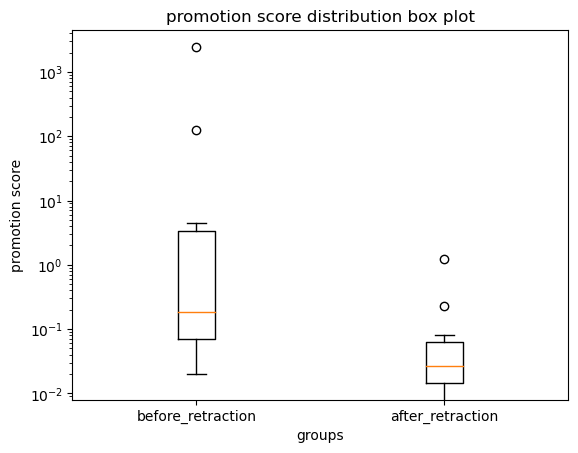

In [3]:
group1 = promotion_effect_score_group("final_data_retracted/before_retraction")
group2 = promotion_effect_score_group("final_data_retracted/after_retraction")


plot_two_groups("final_data_retracted/before_retraction", "final_data_retracted/after_retraction", "promotion score")

/var/folders/ph/zn30w7dn1rx082rwkxmvdwkr0000gq/T/ipykernel_51843/205131292.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  idx = df.groupby('citationName')['citedReferences'].apply(lambda x: find_longest_list_index_in_Series(x))


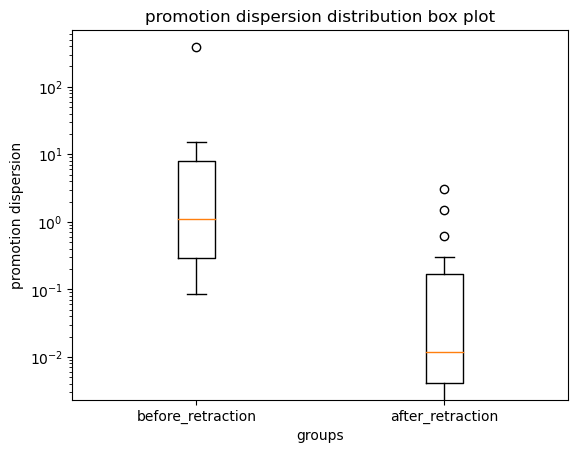

In [4]:
plot_two_groups("final_data_retracted/before_retraction", "final_data_retracted/after_retraction", "promotion dispersion")

In [5]:
statistical_test_two_groups("final_data_retracted/before_retraction", "final_data_retracted/after_retraction", "promotion score")

Mann-Whitney U Statistic: 184.0
P-value: 0.0032301435955866646
Reject the null hypothesis. There is a significant difference between promotion score of before_retraction and after_retraction papers.


/var/folders/ph/zn30w7dn1rx082rwkxmvdwkr0000gq/T/ipykernel_51843/205131292.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  idx = df.groupby('citationName')['citedReferences'].apply(lambda x: find_longest_list_index_in_Series(x))


In [6]:
statistical_test_two_groups("final_data_retracted/before_retraction", "final_data_retracted/after_retraction", "promotion dispersion")

Mann-Whitney U Statistic: 196.0
P-value: 0.0005751660848382262
Reject the null hypothesis. There is a significant difference between promotion dispersion of before_retraction and after_retraction papers.


/var/folders/ph/zn30w7dn1rx082rwkxmvdwkr0000gq/T/ipykernel_51843/205131292.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  idx = df.groupby('citationName')['citedReferences'].apply(lambda x: find_longest_list_index_in_Series(x))


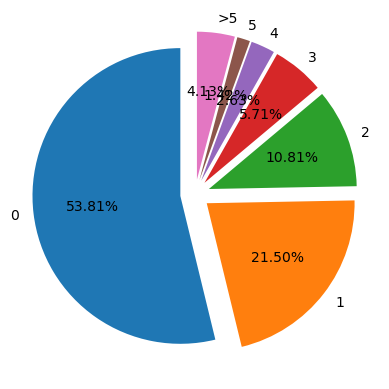

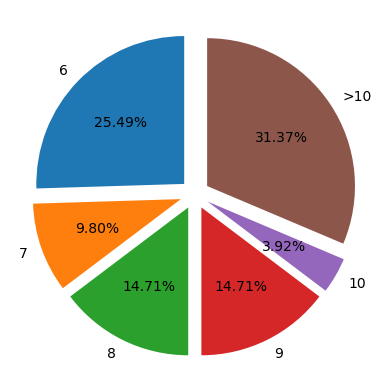

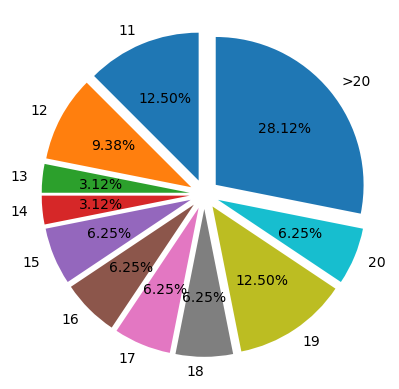

In [10]:
citation_pattern_group("final_data_retracted/before_retraction", "retraction_graphs/citations/before_retraction")

/var/folders/ph/zn30w7dn1rx082rwkxmvdwkr0000gq/T/ipykernel_51843/205131292.py:26: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  idx = df.groupby('citationName')['citedReferences'].apply(lambda x: find_longest_list_index_in_Series(x))


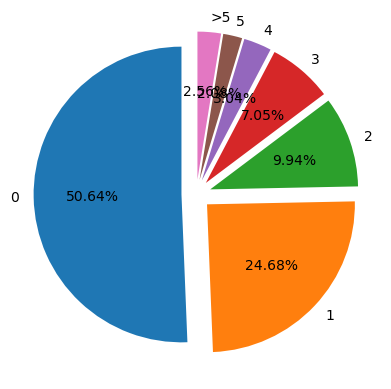

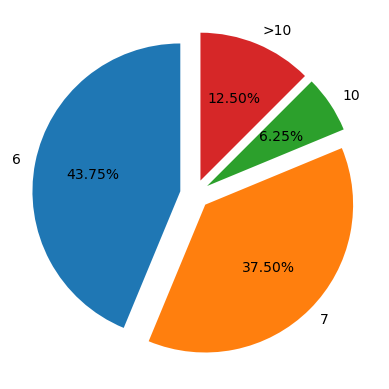

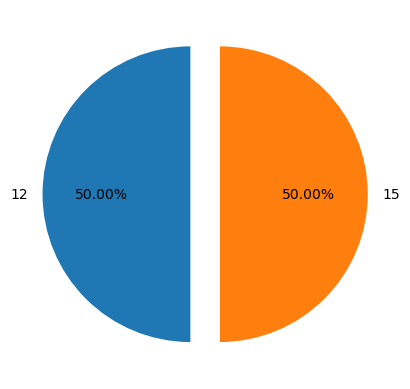

In [11]:
citation_pattern_group("final_data_retracted/after_retraction", "retraction_graphs/citations/after_retraction")